In [22]:
# =============================================================================
# Backtesting strategy - I : Monthly portfolio rebalancing
# Author : Anshul Shrivastava
# =============================================================================

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt

In [23]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [24]:
# Download historical data (monthly) for DJI constituent stocks

tickers = ["MMM","AXP","T","BA","CAT","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UNH","VZ","V","WMT","DIS"]

ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [25]:
################################Backtesting####################################

In [26]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]



calculating monthly return for  MMM
calculating monthly return for  AXP
calculating monthly return for  T
calculating monthly return for  BA
calculating monthly return for  CAT
calculating monthly return for  CSCO
calculating monthly return for  KO
calculating monthly return for  XOM
calculating monthly return for  GE
calculating monthly return for  GS
calculating monthly return for  HD
calculating monthly return for  IBM
calculating monthly return for  INTC
calculating monthly return for  JNJ
calculating monthly return for  JPM
calculating monthly return for  MCD
calculating monthly return for  MRK
calculating monthly return for  MSFT
calculating monthly return for  NKE
calculating monthly return for  PFE
calculating monthly return for  PG
calculating monthly return for  TRV
calculating monthly return for  UNH
calculating monthly return for  VZ
calculating monthly return for  V
calculating monthly return for  WMT
calculating monthly return for  DIS


In [27]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

In [28]:
#calculating overall strategy's KPIs

In [29]:
#Arguments
m = 6 #m = number of stock in the portfolio
x = 3 #x = number of underperforming stocks to be removed from portfolio monthly

In [30]:
cagr_portfolio = CAGR(pflio(return_df,m,x)) * 100

['MMM', 'AXP', 'T', 'BA', 'CAT', 'CSCO']
['MMM', 'AXP', 'CAT', 'NKE', 'UNH', 'MSFT']
['AXP', 'NKE', 'MSFT', 'IBM', 'MSFT', 'MCD']
['AXP', 'MCD', 'MCD', 'PG', 'VZ', 'KO']
['PG', 'VZ', 'INTC', 'IBM', 'VZ', 'T']
['INTC', 'IBM', 'T', 'CAT', 'TRV', 'CSCO']
['INTC', 'IBM', 'CAT', 'HD', 'BA', 'PFE']
['HD', 'BA', 'PFE', 'GE', 'PFE', 'HD']
['HD', 'GE', 'HD', 'GS', 'CAT', 'MSFT']
['HD', 'HD', 'MSFT', 'V', 'PG', 'DIS']
['HD', 'HD', 'DIS', 'JPM', 'AXP', 'GS']
['HD', 'HD', 'AXP', 'TRV', 'VZ', 'T']
['TRV', 'VZ', 'T', 'WMT', 'DIS', 'T']
['VZ', 'WMT', 'DIS', 'MRK', 'XOM', 'JNJ']
['WMT', 'MRK', 'JNJ', 'MRK', 'WMT', 'NKE']
['WMT', 'WMT', 'NKE', 'CSCO', 'HD', 'UNH']
['WMT', 'WMT', 'HD', 'GE', 'JPM', 'GS']
['HD', 'JPM', 'GS', 'GS', 'TRV', 'V']
['HD', 'TRV', 'V', 'CSCO', 'V', 'NKE']
['CSCO', 'NKE', 'GS', 'JPM', 'INTC', 'NKE']
['GS', 'JPM', 'GS', 'PG', 'CAT', 'TRV']
['JPM', 'PG', 'TRV', 'VZ', 'AXP', 'JPM']
['TRV', 'VZ', 'AXP', 'BA', 'NKE', 'AXP']
['VZ', 'BA', 'NKE', 'MSFT', 'DIS', 'VZ']
['BA', 'MSFT', 'DIS'

In [31]:
sharpe_portfolio = sharpe(pflio(return_df,m,x),0.025)

['MMM', 'AXP', 'T', 'BA', 'CAT', 'CSCO']
['MMM', 'AXP', 'CAT', 'NKE', 'UNH', 'MSFT']
['AXP', 'NKE', 'MSFT', 'IBM', 'MSFT', 'MCD']
['AXP', 'MCD', 'MCD', 'PG', 'VZ', 'KO']
['PG', 'VZ', 'INTC', 'IBM', 'VZ', 'T']
['INTC', 'IBM', 'T', 'CAT', 'TRV', 'CSCO']
['INTC', 'IBM', 'CAT', 'HD', 'BA', 'PFE']
['HD', 'BA', 'PFE', 'GE', 'PFE', 'HD']
['HD', 'GE', 'HD', 'GS', 'CAT', 'MSFT']
['HD', 'HD', 'MSFT', 'V', 'PG', 'DIS']
['HD', 'HD', 'DIS', 'JPM', 'AXP', 'GS']
['HD', 'HD', 'AXP', 'TRV', 'VZ', 'T']
['TRV', 'VZ', 'T', 'WMT', 'DIS', 'T']
['VZ', 'WMT', 'DIS', 'MRK', 'XOM', 'JNJ']
['WMT', 'MRK', 'JNJ', 'MRK', 'WMT', 'NKE']
['WMT', 'WMT', 'NKE', 'CSCO', 'HD', 'UNH']
['WMT', 'WMT', 'HD', 'GE', 'JPM', 'GS']
['HD', 'JPM', 'GS', 'GS', 'TRV', 'V']
['HD', 'TRV', 'V', 'CSCO', 'V', 'NKE']
['CSCO', 'NKE', 'GS', 'JPM', 'INTC', 'NKE']
['GS', 'JPM', 'GS', 'PG', 'CAT', 'TRV']
['JPM', 'PG', 'TRV', 'VZ', 'AXP', 'JPM']
['TRV', 'VZ', 'AXP', 'BA', 'NKE', 'AXP']
['VZ', 'BA', 'NKE', 'MSFT', 'DIS', 'VZ']
['BA', 'MSFT', 'DIS'

In [32]:
max_drawdown_portfolio = max_dd(pflio(return_df,m,x)) * 100

['MMM', 'AXP', 'T', 'BA', 'CAT', 'CSCO']
['MMM', 'AXP', 'CAT', 'NKE', 'UNH', 'MSFT']
['AXP', 'NKE', 'MSFT', 'IBM', 'MSFT', 'MCD']
['AXP', 'MCD', 'MCD', 'PG', 'VZ', 'KO']
['PG', 'VZ', 'INTC', 'IBM', 'VZ', 'T']
['INTC', 'IBM', 'T', 'CAT', 'TRV', 'CSCO']
['INTC', 'IBM', 'CAT', 'HD', 'BA', 'PFE']
['HD', 'BA', 'PFE', 'GE', 'PFE', 'HD']
['HD', 'GE', 'HD', 'GS', 'CAT', 'MSFT']
['HD', 'HD', 'MSFT', 'V', 'PG', 'DIS']
['HD', 'HD', 'DIS', 'JPM', 'AXP', 'GS']
['HD', 'HD', 'AXP', 'TRV', 'VZ', 'T']
['TRV', 'VZ', 'T', 'WMT', 'DIS', 'T']
['VZ', 'WMT', 'DIS', 'MRK', 'XOM', 'JNJ']
['WMT', 'MRK', 'JNJ', 'MRK', 'WMT', 'NKE']
['WMT', 'WMT', 'NKE', 'CSCO', 'HD', 'UNH']
['WMT', 'WMT', 'HD', 'GE', 'JPM', 'GS']
['HD', 'JPM', 'GS', 'GS', 'TRV', 'V']
['HD', 'TRV', 'V', 'CSCO', 'V', 'NKE']
['CSCO', 'NKE', 'GS', 'JPM', 'INTC', 'NKE']
['GS', 'JPM', 'GS', 'PG', 'CAT', 'TRV']
['JPM', 'PG', 'TRV', 'VZ', 'AXP', 'JPM']
['TRV', 'VZ', 'AXP', 'BA', 'NKE', 'AXP']
['VZ', 'BA', 'NKE', 'MSFT', 'DIS', 'VZ']
['BA', 'MSFT', 'DIS'

In [33]:
#calculating KPIs for Index buy and hold strategy over the same period

In [34]:
DJI = yf.download("^DJI",dt.date.today()-dt.timedelta(3650),dt.date.today(),interval='1mo')
DJI["mon_ret"] = DJI["Adj Close"].pct_change().fillna(0)

[*********************100%***********************]  1 of 1 completed


In [35]:
cagr_benchmark = CAGR(DJI) * 100

In [36]:
sharpe_benchmark = sharpe(DJI,0.025)

In [37]:
max_drawdown_benchmark = max_dd(DJI) * 100

In [38]:
#comparing KPI's of Portfolio Rebalancing Strategy vs Benchmark

In [39]:
print("Strategy : ")
print("CAGR : "+str(cagr_portfolio))
print("Sharpe Ratio : "+str(sharpe_portfolio))
print("Max-Drawdown : "+str(max_drawdown_portfolio))

Strategy : 
CAGR : 14.602219019581586
Sharpe Ratio : 0.8869375300183313
Max-Drawdown : 22.645414192498748


In [40]:
print("Benchmark : ")
print("CAGR : "+str(cagr_benchmark))
print("Sharpe Ratio : "+str(sharpe_benchmark))
print("Max-Drawdown : "+str(max_drawdown_benchmark))

Benchmark : 
CAGR : 10.527580048068753
Sharpe Ratio : 0.5853821307144546
Max-Drawdown : 23.20126616506341


['MMM', 'AXP', 'T', 'BA', 'CAT', 'CSCO']
['MMM', 'AXP', 'CAT', 'NKE', 'UNH', 'MSFT']
['AXP', 'NKE', 'MSFT', 'IBM', 'MSFT', 'MCD']
['AXP', 'MCD', 'MCD', 'PG', 'VZ', 'KO']
['PG', 'VZ', 'INTC', 'IBM', 'VZ', 'T']
['INTC', 'IBM', 'T', 'CAT', 'TRV', 'CSCO']
['INTC', 'IBM', 'CAT', 'HD', 'BA', 'PFE']
['HD', 'BA', 'PFE', 'GE', 'PFE', 'HD']
['HD', 'GE', 'HD', 'GS', 'CAT', 'MSFT']
['HD', 'HD', 'MSFT', 'V', 'PG', 'DIS']
['HD', 'HD', 'DIS', 'JPM', 'AXP', 'GS']
['HD', 'HD', 'AXP', 'TRV', 'VZ', 'T']
['TRV', 'VZ', 'T', 'WMT', 'DIS', 'T']
['VZ', 'WMT', 'DIS', 'MRK', 'XOM', 'JNJ']
['WMT', 'MRK', 'JNJ', 'MRK', 'WMT', 'NKE']
['WMT', 'WMT', 'NKE', 'CSCO', 'HD', 'UNH']
['WMT', 'WMT', 'HD', 'GE', 'JPM', 'GS']
['HD', 'JPM', 'GS', 'GS', 'TRV', 'V']
['HD', 'TRV', 'V', 'CSCO', 'V', 'NKE']
['CSCO', 'NKE', 'GS', 'JPM', 'INTC', 'NKE']
['GS', 'JPM', 'GS', 'PG', 'CAT', 'TRV']
['JPM', 'PG', 'TRV', 'VZ', 'AXP', 'JPM']
['TRV', 'VZ', 'AXP', 'BA', 'NKE', 'AXP']
['VZ', 'BA', 'NKE', 'MSFT', 'DIS', 'VZ']
['BA', 'MSFT', 'DIS'

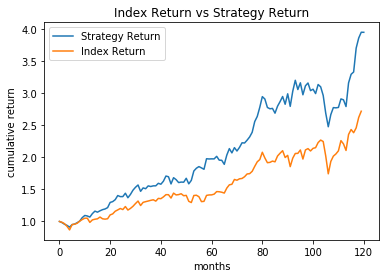

In [41]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])
